In [1]:
from dm_control import mjcf
from dm_control import mujoco
from dm_control.mujoco.wrapper.mjbindings import enums


#General
import numpy as np
import pandas as pd
import os
import math


#Graphics-related
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import PIL.Image

# Internal loading of video libraries.

# Use svg backend for figure rendering
%config InlineBackend.figure_format = 'svg'

# Font sizes
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

# Inline video helper function
if os.environ.get('COLAB_NOTEBOOK_TEST', False):
  # We skip video generation during tests, as it is quite expensive.
  display_video = lambda *args, **kwargs: None
else:
  def display_video(frames, framerate=30):
    height, width, _ = frames[0].shape
    dpi = 70
    orig_backend = matplotlib.get_backend()
    matplotlib.use('Agg')  # Switch to headless 'Agg' to inhibit figure rendering.
    fig, ax = plt.subplots(1, 1, figsize=(width / dpi, height / dpi), dpi=dpi)
    matplotlib.use(orig_backend)  # Switch back to the original backend.
    ax.set_axis_off()
    ax.set_aspect('equal')
    ax.set_position([0, 0, 1, 1])
    im = ax.imshow(frames[0])
    def update(frame):
      im.set_data(frame)
      return [im]
    interval = 1000/framerate
    anim = animation.FuncAnimation(fig=fig, func=update, frames=frames,
                                   interval=interval, blit=True, repeat=False)
    return HTML(anim.to_html5_video())

# Seed numpy's global RNG so that cell outputs are deterministic. We also try to
# use RandomState instances that are local to a single cell wherever possible.
np.random.seed(42)


# Simplified model for adhesion: Brick

Start Conditions: On ground, Adhesion ON

Gravity: Upwards

End Condition: Gravity inverted


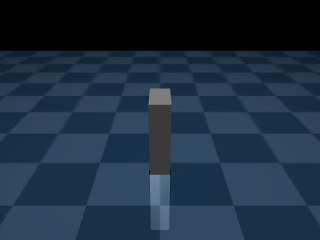

In [2]:
block_on_floor = """
<mujoco model="block_on_floor">
  <option integrator="Euler"/>
  <option timestep="5e-05" gravity = "0 0 +9.81" integrator="Euler" solver="Newton" iterations="1000" tolerance="1e-12" noslip_iterations="100" noslip_tolerance="1e-08" mpr_iterations="100"/>
  <compiler boundmass="1e-06" boundinertia="1e-06" angle="radian" eulerseq="xyz" discardvisual="true" convexhull="true" fusestatic="true"/>
  <size njmax="4096" nconmax="4096"/>
    <visual>
    <global offwidth="1280" offheight="720"/>
    <quality shadowsize="1024" offsamples="4" numslices="28" numstacks="16" numquads="4"/>
    <map stiffness="100.0" stiffnessrot="500.0" force="2.0" torque="0.001" alpha="0.3" fogstart="3.0" fogend="10.0" znear="0.1" zfar="3000.0" haze="0.3" shadowclip="1.0" shadowscale="0.3" actuatortendon="2.0"/>
    <scale forcewidth="12.0" contactwidth="12.0" contactheight="50.0" connect="1.0" com="1.0" camera="1.0" light="1.0" selectpoint="1.0" jointlength="1.0" jointwidth="1.0" actuatorlength="1.0" actuatorwidth="1.0" framelength="0.01" framewidth="0.01" constraint="0.01" slidercrank="0.01"/>
  </visual>
  <statistic meanmass="1.0" meaninertia="1.0" meansize="1.0"/>
  <default>
    <default class="nmf"/>
  </default>
  <asset>
    <texture name="grid" type="2d" builtin="checker" rgb1=".1 .2 .3" 
     rgb2=".2 .3 .4" width="300" height="300"/>
    <material name="grid" texture="grid" texrepeat="8 8" reflectance=".2"/>
  </asset>
  <worldbody>
    <geom size=".2 .2 .01" type="plane" material="grid"/>
    <light pos="0 0 .6"/>
    <camera name="closeup" pos="0 -.1 .07" xyaxes="1 0 0 0 1 2"/>
    <body name="top" pos="-7.48e-18  1.21e-16  0.0149">
      <freejoint/>
      <geom name="box" type="box" size="0.004 .008 0.015"/>
    </body>
  </worldbody>
  <actuator>
    <adhesion name="adhere_box_floor" body="top" ctrlrange="0.001 0.003" gain="15"/> 
  </actuator> 

</mujoco>
"""
model_block = mjcf.from_xml_string(block_on_floor)
physics = mjcf.Physics.from_mjcf_model(model_block)
#physics = mujoco.Physics.from_xml_string(block_on_floor)
PIL.Image.fromarray(physics.render(camera_id='closeup'))

#the block sticks to the floor at 0.002 and flies away at 0.002

#gravity is by default implemented as [0.    0.   -9.81], you can check by using: physics.model.opt.gravity

In [3]:
physics.named.data.xpos

FieldIndexer(xpos):
          x         y         z         
0 world [ 0         0         0       ]
1   top [-7.48e-18  1.21e-16  0.0149  ]

In [4]:
physics.model.opt.gravity

array([0.  , 0.  , 9.81])

In [5]:
adhesion_actuators = [actuator for actuator in model_block.find_all('actuator')
             if actuator.tag == 'adhesion']

In [6]:
adhesion_actuators

[MJCF Element: <adhesion name="adhere_box_floor" class="/" ctrlrange="0.001 0.0030000000000000001" body="top" gain="15"/>]

In [7]:
#@title Video of the tippe-top {vertical-output: true}

duration = 4    # (seconds)
framerate = 60  # (Hz)
time_change_adhesion = 2
tol = 0.00001

# Simulate and display video.
frames = []
physics.reset()  # Reset to keyframe 0 (load a saved state). -> 0 wont work because I dont save the state
while physics.data.time < duration:

  for adh_act in adhesion_actuators:
    if time_change_adhesion < physics.data.time:
      physics.bind(adh_act).ctrl = 0
    else: 
      physics.bind(adh_act).ctrl = 1


  physics.step()
  if len(frames) < (physics.data.time) * framerate:
    pixels = physics.render(camera_id='closeup')
    frames.append(pixels)
#display_video(frames, framerate)

In [8]:
display_video(frames, framerate)

In [9]:
physics.reset()

In [10]:
physics.data.time

0.0

In [11]:
physics.model.opt.gravity

array([0.  , 0.  , 9.81])

In [12]:
physics.named.data.xpos #first put the gravity negative -> use the resulting position as the position of contact. Then change the gravity direction

FieldIndexer(xpos):
          x         y         z         
0 world [ 0         0         0       ]
1   top [-7.48e-18  1.21e-16  0.0149  ]

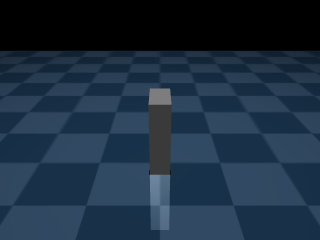

In [13]:
PIL.Image.fromarray(frames[2])

Now lets try this with the xml file for the walking fly.

# Adhesion outside of XML: 

**Attention:** Although the actuator is not directly added in the XML file it must be initialized before the creation of the phyics environment. 

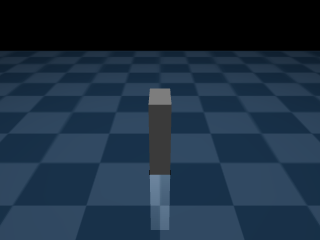

In [8]:
block_on_floor_2 = """
<mujoco model="block_on_floor">
  <option integrator="Euler"/>
  <option timestep="5e-05" gravity = "0 0 +9.81" integrator="Euler" solver="Newton" iterations="1000" tolerance="1e-12" noslip_iterations="100" noslip_tolerance="1e-08" mpr_iterations="100"/>
  <compiler boundmass="1e-06" boundinertia="1e-06" angle="radian" eulerseq="xyz" discardvisual="true" convexhull="true" fusestatic="true"/>
  <size njmax="4096" nconmax="4096"/>
    <visual>
    <global offwidth="1280" offheight="720"/>
    <quality shadowsize="1024" offsamples="4" numslices="28" numstacks="16" numquads="4"/>
    <map stiffness="100.0" stiffnessrot="500.0" force="2.0" torque="0.001" alpha="0.3" fogstart="3.0" fogend="10.0" znear="0.1" zfar="3000.0" haze="0.3" shadowclip="1.0" shadowscale="0.3" actuatortendon="2.0"/>
    <scale forcewidth="12.0" contactwidth="12.0" contactheight="50.0" connect="1.0" com="1.0" camera="1.0" light="1.0" selectpoint="1.0" jointlength="1.0" jointwidth="1.0" actuatorlength="1.0" actuatorwidth="1.0" framelength="0.01" framewidth="0.01" constraint="0.01" slidercrank="0.01"/>
  </visual>
  <statistic meanmass="1.0" meaninertia="1.0" meansize="1.0"/>
  <default>
    <default class="nmf"/>
  </default>
  <asset>
    <texture name="grid" type="2d" builtin="checker" rgb1=".1 .2 .3" 
     rgb2=".2 .3 .4" width="300" height="300"/>
    <material name="grid" texture="grid" texrepeat="8 8" reflectance=".2"/>
  </asset>
  <worldbody>
    <geom size=".2 .2 .01" type="plane" material="grid"/>
    <light pos="0 0 .6"/>
    <camera name="closeup" pos="0 -.1 .07" xyaxes="1 0 0 0 1 2"/>
    <body name="top" pos="-7.48e-18  1.21e-16  0.0149">
      <freejoint/>
      <geom name="box" type="box" size="0.004 .008 0.015"/>
    </body>
  </worldbody>

  <actuator>
  </actuator>
</mujoco>
"""

model_block_2 = mjcf.from_xml_string(block_on_floor)

adhesion_act = [model_block_2.actuator.add('adhesion', name = 'adhadh_adhesion', body = 'top', ctrlrange="0 20", gain="15")]
physics_2 = mjcf.Physics.from_mjcf_model(model_block_2)
#physics = mujoco.Physics.from_xml_string(block_on_floor)
PIL.Image.fromarray(physics_2.render(camera_id='closeup'))

#the block sticks to the floor at 0.002 and flies away at 0.002

#gravity is by default implemented as [0.    0.   -9.81], you can check by using: physics.model.opt.gravity

In [9]:
adhesion_act

[MJCF Element: <adhesion name="adhadh_adhesion" class="/" ctrlrange="0 20" body="top" gain="15"/>]

In [10]:
#@title Video of the tippe-top {vertical-output: true}

duration = 4    # (seconds)
framerate = 60  # (Hz)
time_change_adhesion = 2
tol = 0.00001

# Simulate and display video.
frames = []
physics_2.reset()  # Reset to keyframe 0 (load a saved state). -> 0 wont work because I dont save the state
while physics.data.time < duration:

    for adh in adhesion_act:

        if time_change_adhesion < physics.data.time:
            physics_2.bind(adh).ctrl= 2
        else: 
            physics_2.bind(adh).ctrl = 0


    physics.step()
    if len(frames) < (physics_2.data.time) * framerate:
        pixels = physics_2.render(camera_id='closeup')
        frames.append(pixels)
#display_video(frames, framerate)